In [2]:

from datetime import datetime
from goes2go.data import goes_latest, goes_nearesttime



# Loading GOES data


We will use the [GOES-2-GP](https://blaylockbk.github.io/goes2go/_build/html/index.html) package which provides a nice API for easy queries.

This tutorial: https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm is also useful for data wrangling.


We are querying the GOES-R data series which is composed of GOES-16 and GOES-17. In particular we want surface temperature readings from the Advanced Baseline Imager. https://www.goes-r.gov/products/overview.html

There are different data "areas". See https://www.star.nesdis.noaa.gov/goes/index.php
We want the full disk of temperature, which is `ABI-L2-LSTF`. See https://docs.opendata.aws/noaa-goes16/cics-readme.html

There are also some useful slides here: https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf


First lets load the data at a particular datetime:

In [58]:
g = goes_nearesttime(datetime(2018, 4, 19,17),
                       satellite='goes16',
                       product='ABI-L2-LSTF',
                       return_as='xarray',save_dir='/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/')

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-LSTF      |
 |    Domain: F                |
📦 Finished downloading [1] files to [/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/noaa-goes16/ABI-L2-LSTF].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

/home/k/kimpson/bin/conda/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:650: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  nearest_time_index = df.index.get_loc(attime, method="nearest")


This data is loaded as an `xarray` object:

In [59]:
g

<xarray.Dataset>
Dimensions:                                 (y: 1086, x: 1086,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1519 ... -0.1519
  * x                                       (x) float32 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    retrieval_local_zenith_angle            float32 ...
    quantitative_local_zenith_angle         float32 ...
    solar_zenith_angle                      float32 ...
    dataset_name                            <U72 'OR_ABI-L2-LSTF-M3_G16_s2018...
    date_created                            <U22 '2018-04-19T17:20:45.3Z'
    time_coverage_start                     <U22 '2018-04-19T17:00:43.2Z'
    time_coverage_end                       <U22 '2018-04-19T17:11:19.9Z'
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/26)
    LST                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    filename                                <U108 'noaa-goes16/ABI-L2-LSTF/20...
Attributes: (12/26)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    processing_level:          National Aeronautics and Space Administration ...
    cdm_data_type:             Image
    timeline_id:               ABI Mode 3
    production_data_source:    Realtime
    id:                        9cc9d678-ae56-4687-9072-107de3655920
    path:                      ['noaa-goes16/ABI-L2-LSTF/2018/109/17/OR_ABI-L...

It will prove useful to extract just the info we want as follows:

In [60]:
import numpy as np
import pandas as pd

def extract_data(ds):
    
    #Some usful stuff for lat/lon extraction
    proj_info = ds.variables['goes_imager_projection'].attrs
    lon_origin = proj_info['longitude_of_projection_origin']
    H = proj_info['perspective_point_height']+proj_info['semi_major_axis']
    r_eq = proj_info['semi_major_axis']
    r_pol = proj_info['semi_minor_axis']
    
    # grid info
    lat_rad_1d = ds.variables['x'][:]
    lon_rad_1d = ds.variables['y'][:]
    
    
    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    
    
    #Conversion. Some NaNs, but these are zero valued regions
    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    
    #The actual temperature data
    data = ds.variables['LST'][:]
    time = ds.t.data
    
    
    #
    y = lat.flatten()
    x = lon.flatten()
    z = data.data.flatten() 
    
    
    
    
    
    
    
    
    df = pd.DataFrame(data={'longitude': x,
                       'latitude':       y,
                       'temperature':    z
                        })
    df['time'] = time.flatten()[0]
    
    df_filtered = df.query('-70 < latitude < +70')
    
    return df_filtered.dropna()

In [61]:
df = extract_data(g)

/tmp/ipykernel_19822/2578906959.py:29: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


In [62]:
df

,longitude,latitude,temperature,time
14652,-77.519859,69.998039,260.067505,2018-04-19 17:06:01.574386944
14653,-77.222786,69.994141,260.062500,2018-04-19 17:06:01.574386944
14654,-76.926102,69.992409,260.339996,2018-04-19 17:06:01.574386944
14660,-75.148064,69.984543,261.119995,2018-04-19 17:06:01.574386944
14661,-74.851913,69.984543,261.179993,2018-04-19 17:06:01.574386944
...,...,...,...,...
1148512,-59.120049,-64.453407,255.342499,2018-04-19 17:06:01.574386944
1149587,-61.662956,-64.656296,256.515015,2018-04-19 17:06:01.574386944
1149590,-60.916656,-64.693077,258.472504,2018-04-19 17:06:01.574386944
1150671,-61.974274,-64.982117,251.747498,2018-04-19 17:06:01.574386944


In [63]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.colorbar as cb 

def plot_map(df,vmin,vmax,cmap):
    
    #Get all data as vectors
    x = df.longitude
    y = df.latitude
    z = df.temperature
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z)),
               linewidths=1, alpha=.7
               )

    
    #ax.set_xlim(-150,150)
    plt.show()
    

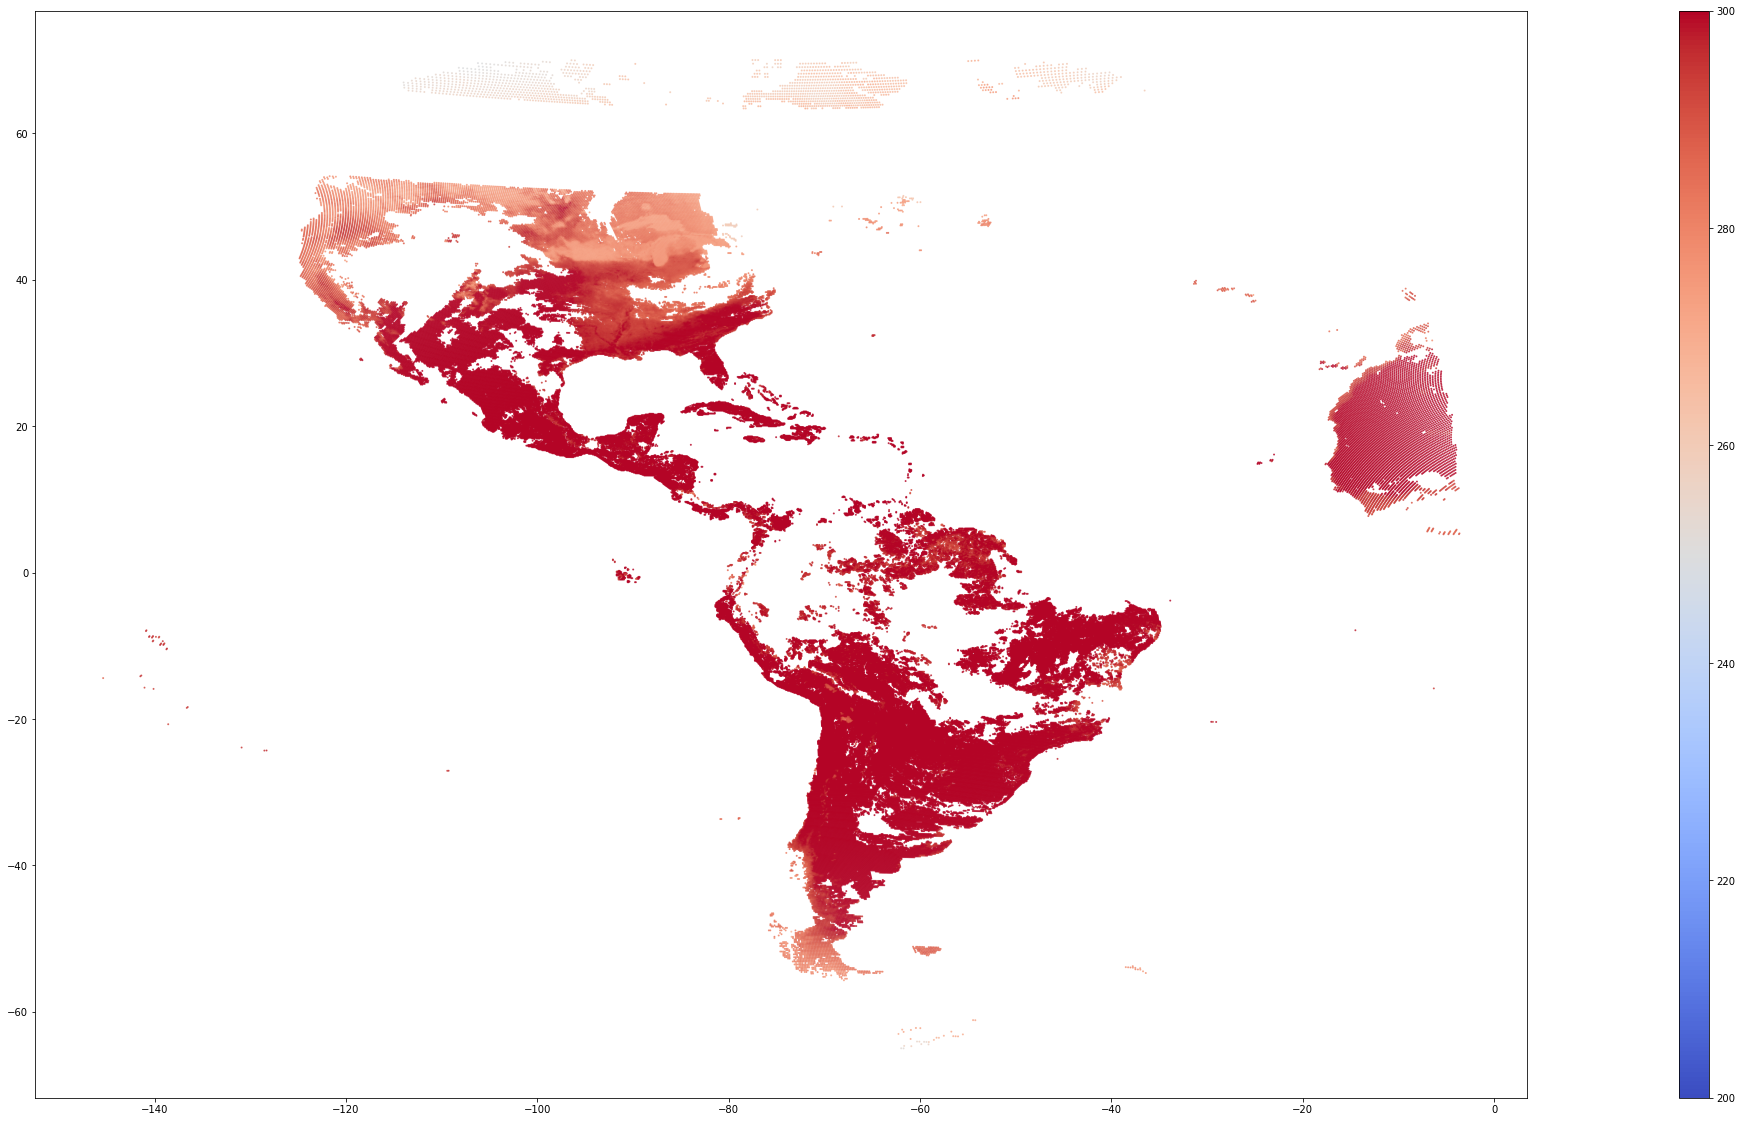

In [64]:
plot_map(df,vmin=200,vmax=300,cmap=plt.cm.coolwarm)

In [35]:
#df.to_pickle("/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/GOES.pkl")

In [65]:
df.to_csv('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/GOES.csv')